In [8]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
import gc
from tqdm import tqdm
from scipy import interpolate

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.injections.pbh import PBHAccretionInjection
from dm21cm.utils import load_h5_dict
from analysis.limits import get_limits

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

In [9]:
model_latex_dict = {
    'PRc23': r'$\textbf{PR}\,\mathrm{(fid.)}$',
    'PRc50': r'$\textbf{PR-}c_\mathrm{in}+$',
    'PRc10': r'$\textbf{PR-}c_\mathrm{in}-$',
    'PRc29': r'$\textbf{PR-}c_\mathrm{in}+$',
    'PRc14': r'$\textbf{PR-}c_\mathrm{in}-$',
    'PRc23dp': r'$\textbf{PR-}\delta_e+$',
    'PRc23dm': r'$\textbf{PR-}\delta_e-$',
    'PRc23B': r'$\textbf{PR-}B$',
    'PRc23H': r'$\textbf{PR-}H$',
    'BHLl2': r'$\textbf{BHL}$',
}
color_dict = {
    'PRc23': 'k',
    'PRc50': 'C0',
    'PRc10': 'C0',
    'PRc29': 'C0',
    'PRc14': 'C0',
    'PRc23dp': 'C1',
    'PRc23dm': 'C1',
    'PRc23B': 'C2',
    'PRc23H': 'C3',
    'BHLl2': 'k',
}
ls_dict = {
    'PRc23': '-',
    'PRc50': '-',
    'PRc10': '--',
    'PRc29': '-',
    'PRc14': '--',
    'PRc23dp': '-',
    'PRc23dm': '--',
    'PRc23B': '-',
    'PRc23H': '-',
    'BHLl2': ':',
}
zorder_dict = {
    'PRc23': 6,
    'PRc50': 5,
    'PRc10': 4,
    'PRc29': 5,
    'PRc14': 4,
    'PRc23dp': 3,
    'PRc23dm': 2,
    'PRc23B': 1,
    'PRc23H': 0,
    'BHLl2': -1,
}

# pbhacc-L-z

In [10]:
m_PBH = 1e2 # [M_sun]

model_name_s = ['PRc23', 'PRc14', 'PRc29', 'PRc23B', 'PRc23dp', 'PRc23dm', 'PRc23H', 'BHLl2']

z_s = np.geomspace(4, 1000, 100)

unity = (1 * u.eV/u.s/u.cm**3 / c.c**2).to(u.M_sun/u.yr/u.Mpc**3)

cf_halo_power_d = {}
cf_cosmo_power_d = {}
cf_total_power_d = {}
for name in tqdm(model_name_s):
    inj = PBHAccretionInjection(name, m_PBH=m_PBH, f_PBH=1)
    cf_halo_power_d[name] = np.array([inj.inj_power(z, debug='halo only') / (1+z)**3 for z in z_s]) * unity.value
    cf_cosmo_power_d[name] = np.array([inj.inj_power(z, debug='cosmo only') / (1+z)**3 for z in z_s]) * unity.value
    cf_total_power_d[name] = cf_halo_power_d[name] + cf_cosmo_power_d[name]
    del inj
    gc.collect()

100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


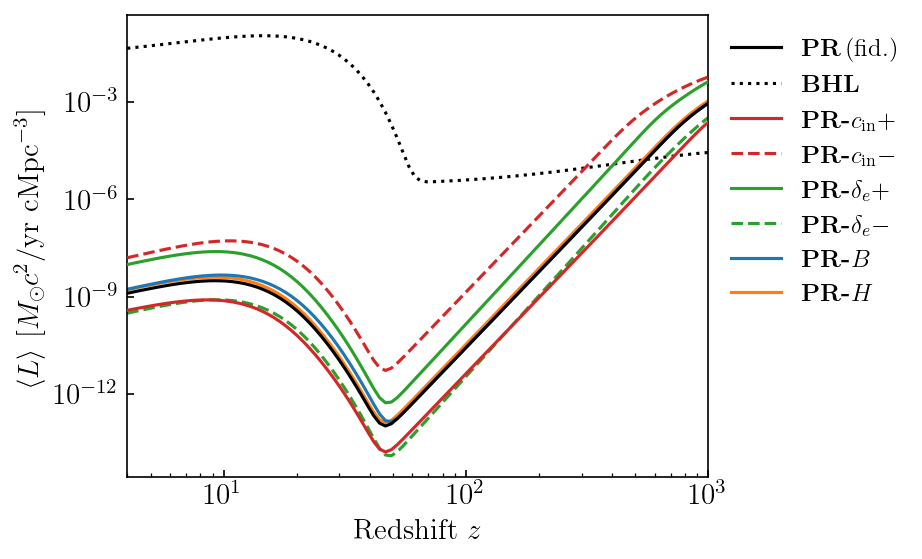

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

text_xy_dict = {mn: None for mn in model_name_s}

plot_mn_s = ['PRc23', 'BHLl2', 'PRc29', 'PRc14', 'PRc23dp', 'PRc23dm', 'PRc23B', 'PRc23H']

for i, mn in enumerate(plot_mn_s):
    label = model_latex_dict[mn] if not text_xy_dict[mn] else None
    ax.plot(z_s, cf_total_power_d[mn], color=color_dict[mn], label=label, zorder=zorder_dict[mn], ls=ls_dict[mn], lw=1.5)
    if text_xy_dict[mn]:
        ax.text(*text_xy_dict[mn], model_latex_dict[mn], color=color_dict[mn], fontsize=12)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(4, 1000))
ax.set(xlabel=r'Redshift $z$', ylabel=r'$\langle L\rangle$ [$M_\odot c^2$/yr cMpc$^{-3}$]')
legend = ax.legend(frameon=False, fontsize=12, ncol=1, bbox_to_anchor=(1, 1))

# fig.savefig('pbhacc-L-z.pdf', bbox_inches='tight')

# pbhacc-L-M

In [11]:
hmfdata = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/hmf/hmf.h5")
z_s = hmfdata['z'] # [1]    | redshift
d_s = hmfdata['d'] # [1]    | delta (overdensity)
m_s = hmfdata['m'] # [Msun] | halo mass

In [12]:
model_name_s = ['PRc23', 'BHLl2', 'PRc29', 'PRc14', 'PRc23dp', 'PRc23dm', 'PRc23B', 'PRc23H']
L_dict = {}

z = 15
m_PBH = 1e2 # [M_sun]

for model_name in model_name_s:
    L_table = np.load(f"../../data/pbh-accretion/L_table_cache/{model_name}/{model_name}_log10m{np.log10(m_PBH):.3f}.npy")
    L_dict[model_name] = interpolate.interp1d(z_s, L_table, axis=0, bounds_error=True)(z)

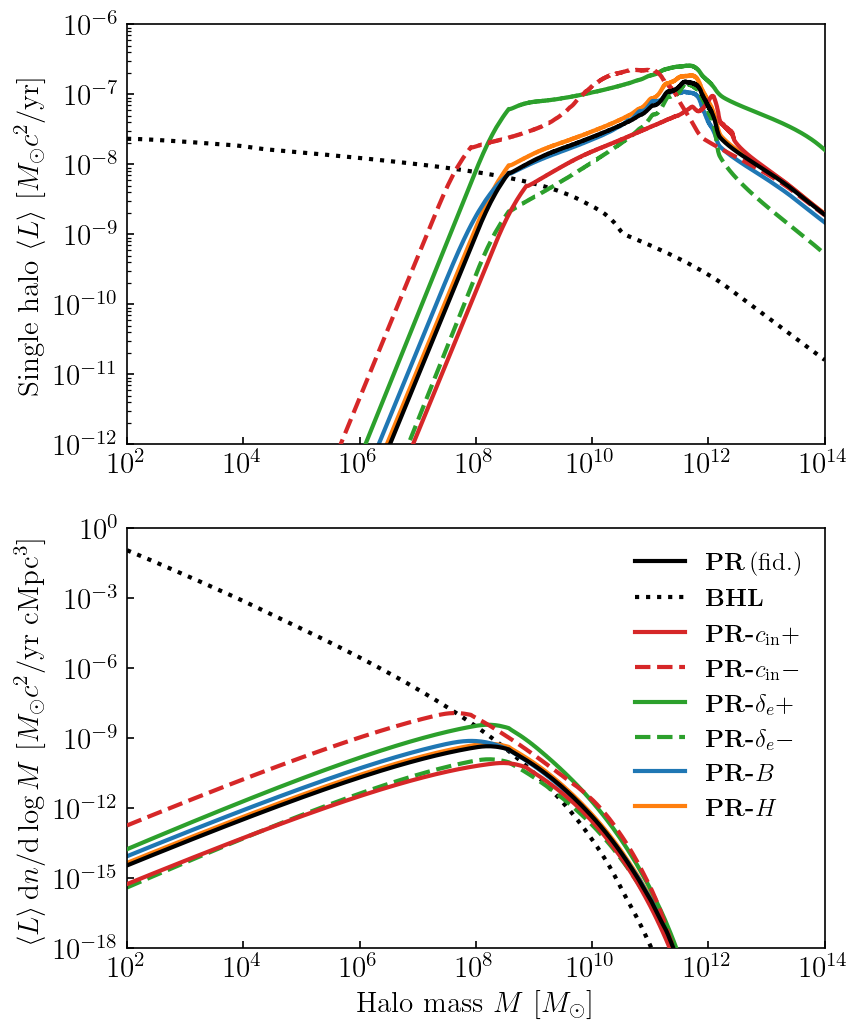

In [13]:
text_log10xy_dict = {mn: None for mn in model_name_s}

fig, axs = plt.subplots(2, 1, figsize=(6, 8) , sharex=False)

ax = axs[0]
for i, mn in enumerate(model_name_s):
    log10xy = text_log10xy_dict[mn]
    if log10xy:
        xy = 10.**np.array(log10xy)
        ax.text(*xy, model_latex_dict[mn], color=color_dict[mn], fontsize=12)
        label = None
    else:
        label = model_latex_dict[mn]
    ax.plot(m_s, L_dict[mn], label=label, color=color_dict[mn], ls=ls_dict[mn], zorder=zorder_dict[mn])

ax.set(xscale='log', yscale='log')
if m_PBH == 1e0:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-14, 1e-8))
elif m_PBH == 1e2:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-12, 1e-6))
elif m_PBH == 1e4:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-10, 1e-4))
ax.set(ylabel=r'Single halo $\langle L\rangle$ [$M_\odot c^2$/yr]')

ax = axs[1]
dndm_s = interpolate.interp1d(z_s, hmfdata['st'], axis=0, bounds_error=True)(z)
for i, mn in enumerate(model_name_s):
    ax.plot(m_s, m_s * dndm_s * L_dict[mn], label=model_latex_dict[mn], color=color_dict[mn], ls=ls_dict[mn], zorder=zorder_dict[mn])

ax.set(xscale='log', yscale='log')
if m_PBH == 1e0:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-20, 1e-2))
elif m_PBH == 1e2:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-18, 1e0))
elif m_PBH == 1e4:
    ax.set(xlim=(1e2, 1e14), ylim=(1e-16, 1e+2))
ax.set(xlabel=r'Halo mass $M$ [$M_\odot$]', ylabel=r'$\langle L\rangle\,\mathrm{d}n/\mathrm{d}\log M$ [$M_\odot c^2$/yr cMpc$^{3}$]')

ax.legend(frameon=False, fontsize=12)

fig.subplots_adjust(hspace=0.2)
fig.savefig('pbhacc-L-M.pdf', bbox_inches='tight')

# pbhacc-L-$\delta$

In [32]:
model_name_s = ['PRc23', 'BHLl2', 'PRc29', 'PRc14', 'PRc23dp', 'PRc23dm', 'PRc23B', 'PRc23H']
L_dict = {}

z = 15
m_PBH = 1e4 # [M_sun]

for model_name in model_name_s:
    prefix = f"{os.environ['DM21CM_DATA_DIR']}/pbhacc_rates/{model_name}/{model_name}_log10m{np.log10(m_PBH):.3f}"
    halo_data = load_h5_dict(prefix + "_halo.h5")
    halo_ps_cond = np.array(halo_data['ps_cond'])
    L_dict[model_name] = interpolate.interp1d(z_s, halo_ps_cond, axis=0, bounds_error=True)(z)
    d_s = halo_data['d']

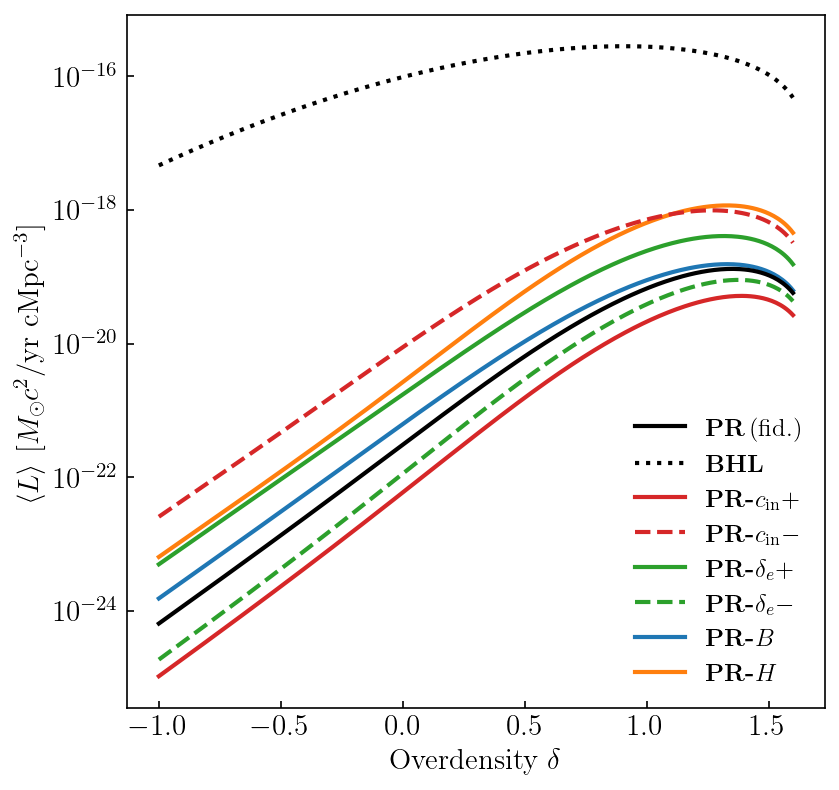

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

ax = axs
for i, mn in enumerate(model_name_s):
    ax.plot(d_s, L_dict[mn], label=model_latex_dict[mn], color=color_dict[mn], ls=ls_dict[mn], zorder=zorder_dict[mn])

ax.set(yscale='log')
ax.set(xlabel=r'Overdensity $\delta$', ylabel=r'$\langle L\rangle$ [$M_\odot c^2$/yr cMpc$^{-3}$]')

ax.legend(frameon=False, fontsize=12)

# fig.savefig('pbhacc-L-delta.pdf', bbox_inches='tight')

# dndM - $\delta$

In [34]:
hmfdata = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/hmf/hmf.h5")
z_s = hmfdata['z'] # [1]    | redshift
d_s = hmfdata['d'] # [1]    | delta (overdensity)
m_s = hmfdata['m'] # [Msun] | halo mass

In [36]:
hmfdata['ps_cond'].shape

(300, 300, 4001)

In [48]:
dm_data = interpolate.interp1d(z_s, hmfdata['ps_cond'], axis=0, bounds_error=True)(z)

d_show_s = [-0.999, -0.5, 0, 0.5, 1, 1.5]
dndm_s = [interpolate.interp1d(d_s, dm_data, axis=0, bounds_error=True)(d) for d in d_show_s]
color_s = mpl.colormaps['plasma'](np.linspace(0, 0.85, len(d_show_s)))

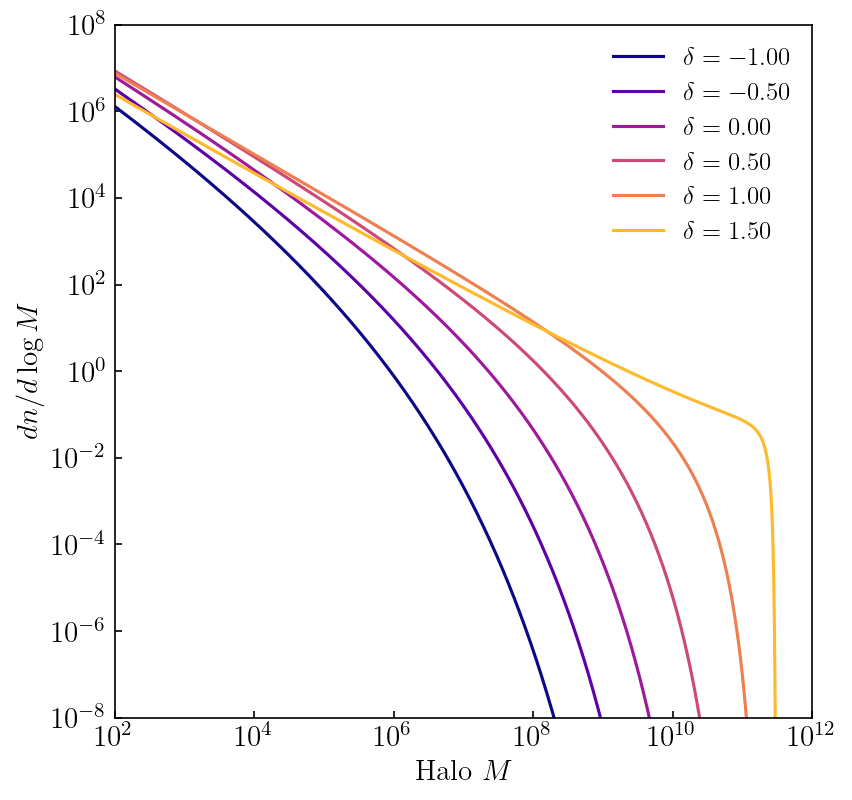

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i, d in enumerate(d_show_s):
    ax.plot(m_s, m_s * dndm_s[i], color=color_s[i], label=fr'$\delta={d:.2f}$', lw=1.5)
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'Halo $M$', ylabel=r'$dn/d\log M$')
ax.set(xlim=(1e2, 1e12), ylim=(1e-8, 1e8))
ax.legend(frameon=False, fontsize=12)

# limits

In [14]:
def plot_limits(ax, channel, **kwargs):
    mass_s, inj_s, sigma_s, limit_s = get_limits(channel)
    upper_limit = limit_s
    model_name = channel.split('-')[1]
    default_kwargs = dict(
        label=model_latex_dict[model_name],
        color=color_dict[model_name],
        ls=ls_dict[model_name],
        zorder=zorder_dict[model_name]
    )
    default_kwargs.update(kwargs)
    ax.plot(mass_s, upper_limit, **default_kwargs)

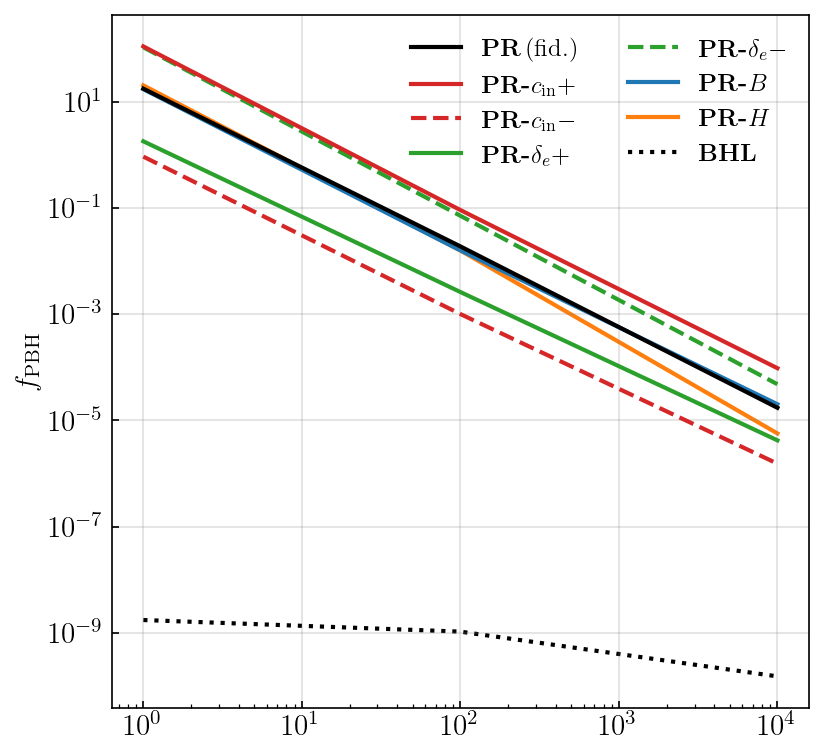

In [24]:
model_name_s = ['PRc23', 'PRc29', 'PRc14', 'PRc23dp', 'PRc23dm', 'PRc23B', 'PRc23H']

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

ax = axs
for model_name in model_name_s:
    plot_limits(ax, f'pbhacc-{model_name}-250630')

model_name = 'BHLl2'
plot_limits(ax, f'pbhacc-{model_name}-250630')

ax.set(xscale='log', yscale='log')
ax.set(ylabel=r'$f_\mathrm{PBH}$')
ax.grid(color='0.5', alpha=0.2, linewidth=1, linestyle='-')
ax.legend(frameon=False, ncol=2)


# ax.set(xscale='log', yscale='log')
# ax.set(xlabel=r'$M_\mathrm{PBH}$ [$M_\odot$]', ylabel=r'$f_\mathrm{PBH}$')
# ax.grid(color='0.5', alpha=0.2, linewidth=1, linestyle='-')
# ax.legend(frameon=False)

fig.savefig('pbhacc-limits.pdf', bbox_inches='tight')

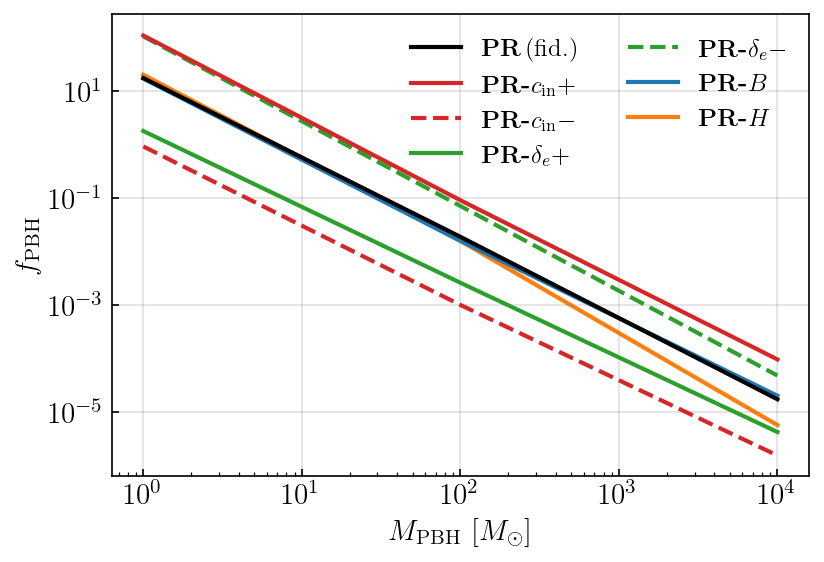

In [17]:
model_name_s = ['PRc23', 'PRc29', 'PRc14', 'PRc23dp', 'PRc23dm', 'PRc23B', 'PRc23H']

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
for model_name in model_name_s:
    plot_limits(ax, f'pbhacc-{model_name}-250630')

ax.set(xscale='log', yscale='log')
ax.set(xlabel='$M_\mathrm{PBH}$ [$M_\odot$]', ylabel=r'$f_\mathrm{PBH}$')
ax.grid(color='0.5', alpha=0.2, linewidth=1, linestyle='-')
ax.legend(frameon=False, ncol=2, loc='upper right')

fig.savefig('pbhacc-limits-PR.pdf', bbox_inches='tight')